# CellNet

- no conclusively best std. though preds with 4 or so luck most interpretable
- vast differences in loss/acc for slighty different sigmas -> too much randomness = bad convergence in data? -> bigger batch or bigger model?

In [1]:
IMAGES = 'all'; AUGS = 'val'
P = 'sigma'; ps = [3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]
#P = 'rmbad'; ps = [0.15]


import ast
from math import prod
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch
import numpy as np

import albumentations as A
from albumentations.pytorch import ToTensorV2

from types import SimpleNamespace as obj

import util.data as data
import util.plot as plot


CUDA = torch.cuda.is_available()
device = torch.device('cuda:0' if CUDA else 'cpu'); print('device =', device)
DRAFT = False if os.getenv('BATCHED_RUN', '0')=='1' else True; print('DRAFT =', DRAFT)

def gpu(x, device=device): return torch.from_numpy(x).float().to(device)
def cpu(x): return x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else np.array(x) if isinstance(x, list) else x

key2text = {'tl': 'Training Loss',     'vl': 'Validation Loss', 
            'ta': 'Training Accuracy', 'va': 'Validation Accuracy', 
            'ti': 'Training Image',    'vi': 'Validation Image',
            'lf': 'Loss Function',     'lr': 'Learning Rate',
            'e' : 'Epoch',             'bs': 'Batch Size',
            'fraction': 'Fraction of Data',  'sparsity': 'Artificial Sparsity',  
            'sigma': 'Gaussian Sigma',        'maxdist': 'Max Distance',
            'rmbad': 'Prop. of Difficult Labels Removed'
            }

CROPSIZE=256

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.8 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


device = cuda:0
DRAFT = False


In [2]:
XNorm = data.mk_XNorm([1,2,4])

def mkAugs(mode):
  T = lambda ts:  A.Compose(transforms=[
    A.PadIfNeeded(CROPSIZE, CROPSIZE, border_mode=0, value=0),
    *ts,
    XNorm(), 
    A.PadIfNeeded(CROPSIZE, CROPSIZE, border_mode=0, value=0),
    ToTensorV2(transpose_mask=True, always_apply=True)], 
    keypoint_params=A.KeypointParams(format='xy', label_fields=['class_labels'], remove_invisible=True) # type: ignore
  )

  vals = [A.D4(),
          ]

  return dict(
    test  = T([]),
    val   = T([A.RandomCrop(CROPSIZE, CROPSIZE, p=1),
               *vals]),
    train = T([
               A.RandomCrop(CROPSIZE, CROPSIZE, p=1),
              #A.RandomSizedCrop(p=1, min_max_height=(CROPSIZE//2, CROPSIZE*2), height=CROPSIZE, width=CROPSIZE),
              # NOTE: issue with resize is that the keypoint sizes will not be updated
               A.Rotate(),
               A.AdvancedBlur(),
               A.Equalize(),
               A.ColorJitter(), 
               A.GaussNoise(),
               *vals])
  )[mode]

batch2cpu = lambda B, z=None, y=None: [obj(**{k:cpu(v) for v,k in zip(b, 'xmklzy')}) 
              for b in zip(B['image'], B['masks'][0], B['keypoints'], B['class_labels'], 
              *([] if z is None else [z]), *([] if y is None else [y]))]

In [3]:
def plot_overlay(B, cfg, ax=None, heat='z'):
  ax = plot.image(B.x, ax=ax)
  plot.heatmap(1-B.m, ax=ax, alpha=lambda x: 0.5*x, color='#000000')
  plot.heatmap(  B.__dict__[heat], ax=ax, alpha=lambda x: 1.0*x, color='#ff0000')
  plot.points(ax, B.k, B.l)
  return ax

def plot_diff(B, cfg, ax=None):
  title = f"Difference between Target and Predicted Heatmap"
  D = B.y-B.z; D[0, 1,0] = -1; D[0, 1,1] = 1 
  ax = plot.image(D, ax=ax, cmap='coolwarm')
  plot.heatmap(1-B.m, ax=ax, alpha=lambda x: 0.2*x, color='#000000')
  plot.points(ax, B.k, B.l)
  return ax

if DRAFT and not CUDA: 
  _cfg = obj(sigma=4, maxdist=26, fraction=1, sparsity=1)
  kp2hm, yunnorm = data.mk_kp2mh_yunnorm([1,2,4], _cfg)

  def plot_grid(grid, **loader_kwargs):
    loader = data.mk_loader([1], cfg=_cfg, bs=prod(grid), **loader_kwargs)
    B = next(iter(loader))
    B = batch2cpu(B, z=kp2hm(B))
    for b,ax in zip(B, plot.grid(grid, [CROPSIZE]*2)[1]):
      plot_overlay(b, _cfg, ax=ax)

  for B in data.mk_loader([1,2,4], cfg=_cfg, bs=1, transforms=mkAugs('test'), shuffle=False):
    ax = plot_overlay(batch2cpu(B, z=kp2hm(B))[0], _cfg)

  plot_grid((3,3), transforms=mkAugs('val'))
  plot_grid((3,3), transforms=mkAugs('train'))

In [4]:
import segmentation_models_pytorch as smp
plt.close('all')

mk_model = lambda: smp.Unet(  # NOTE TODO: check if spefically used model automatically mirror pads in training or inference
    encoder_name="resnet34" if DRAFT else "resnet152",  # 18 34 50 101 152
    encoder_weights=None,
    in_channels=3,
    classes=1,
    activation='sigmoid',
  ).to(device)  

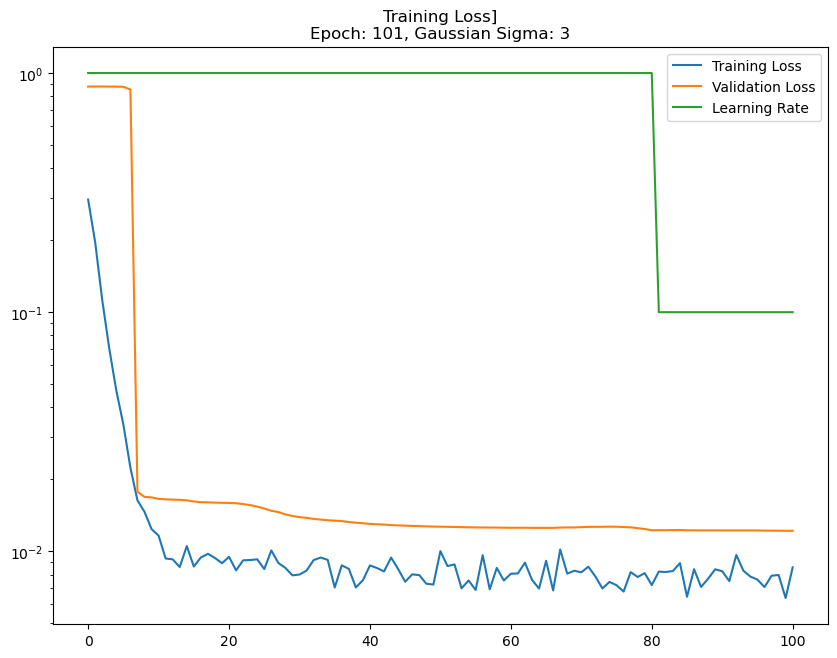

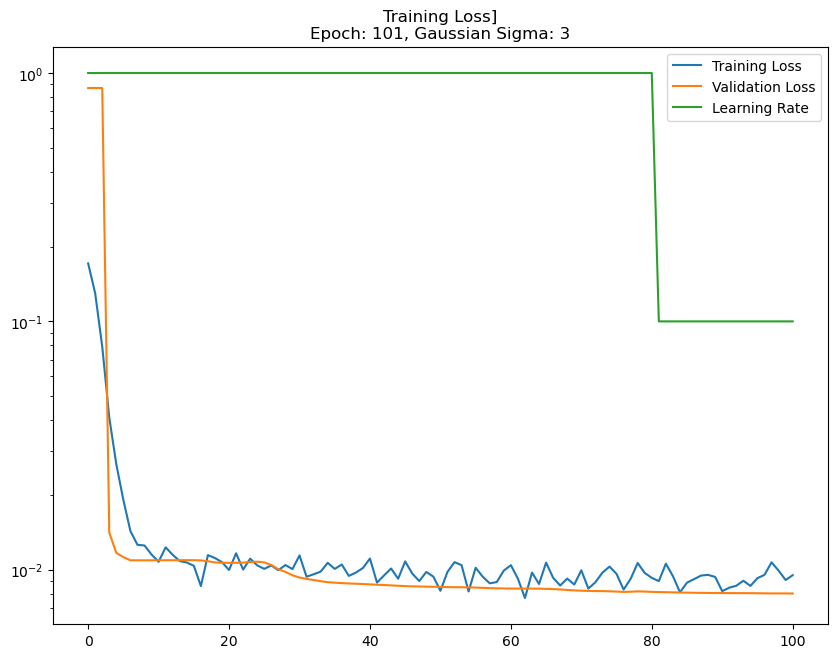

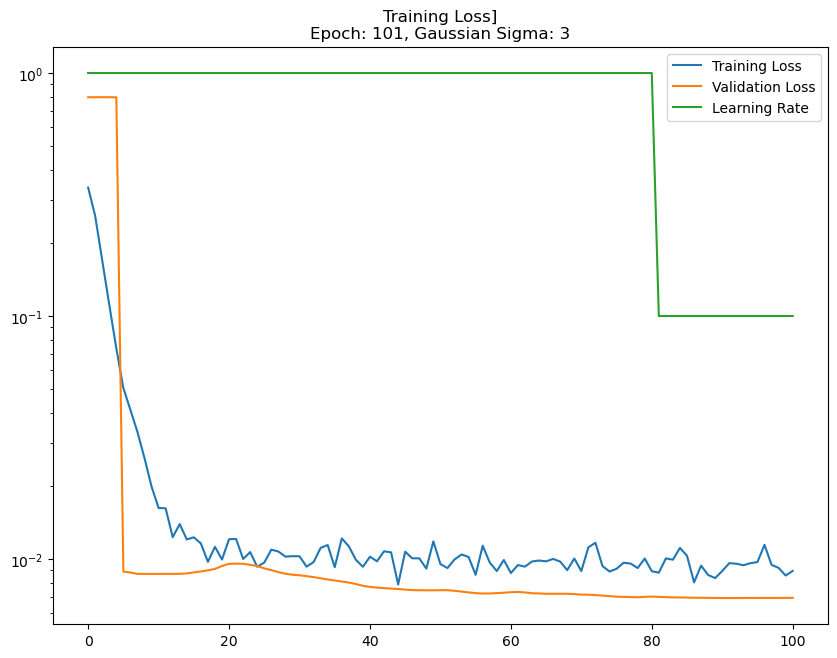

/gpfs/space/home/eckhardt/sanger/results/cellnet/240603-054345-sigma3_7-val-all-RUNNING/util/plot.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.savefig(path, transparent=transparent, pil_kwargs=dict(compress_level=9))


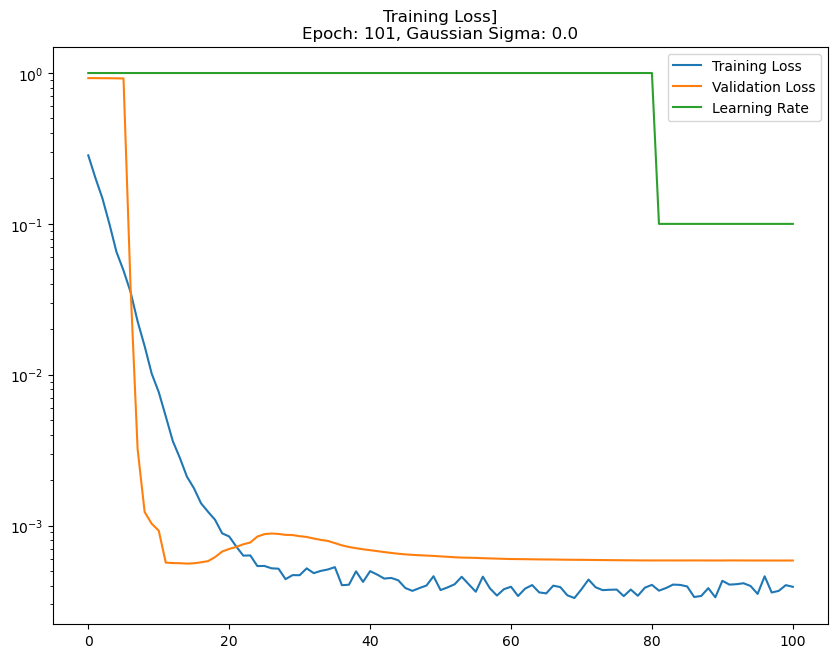

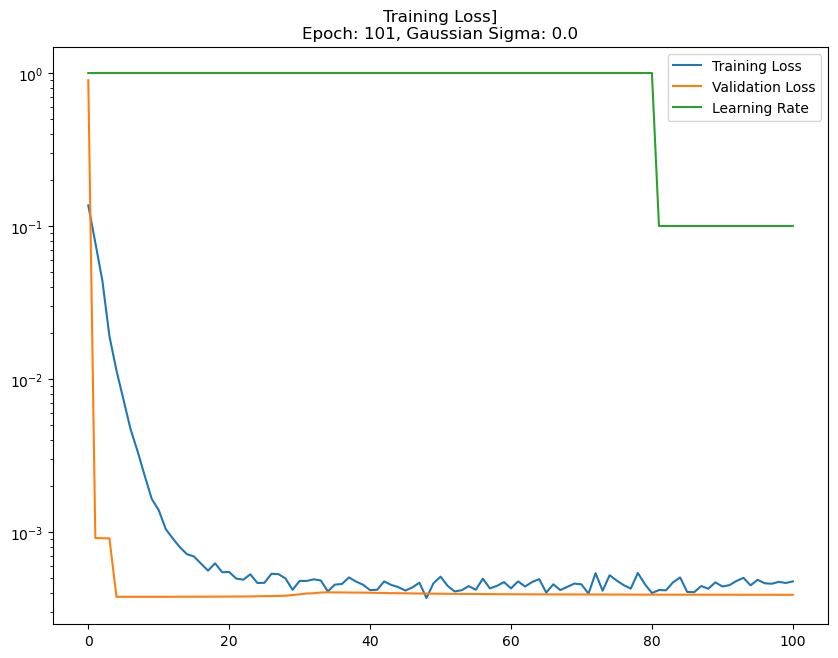

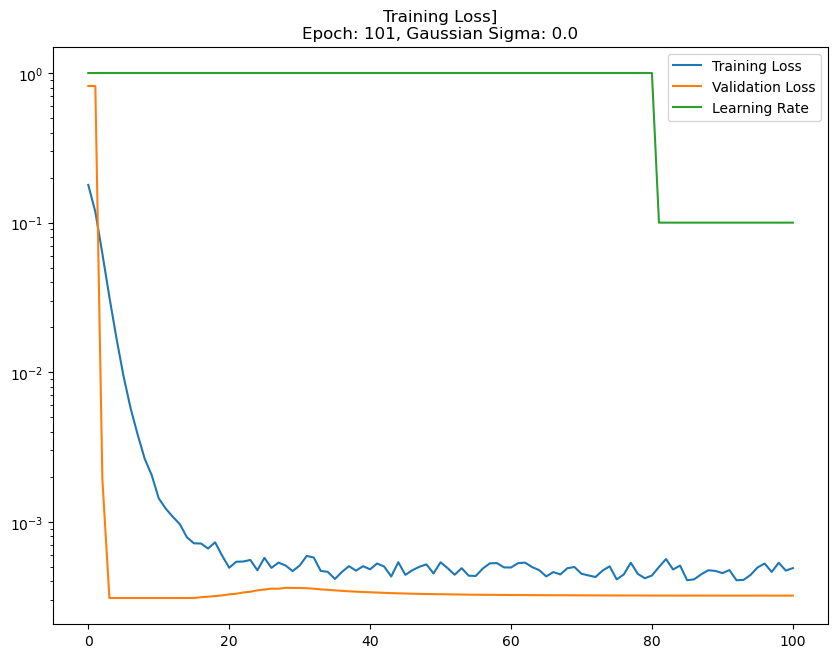

/gpfs/space/home/eckhardt/sanger/results/cellnet/240603-054345-sigma3_7-val-all-RUNNING/util/plot.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.savefig(path, transparent=transparent, pil_kwargs=dict(compress_level=9))


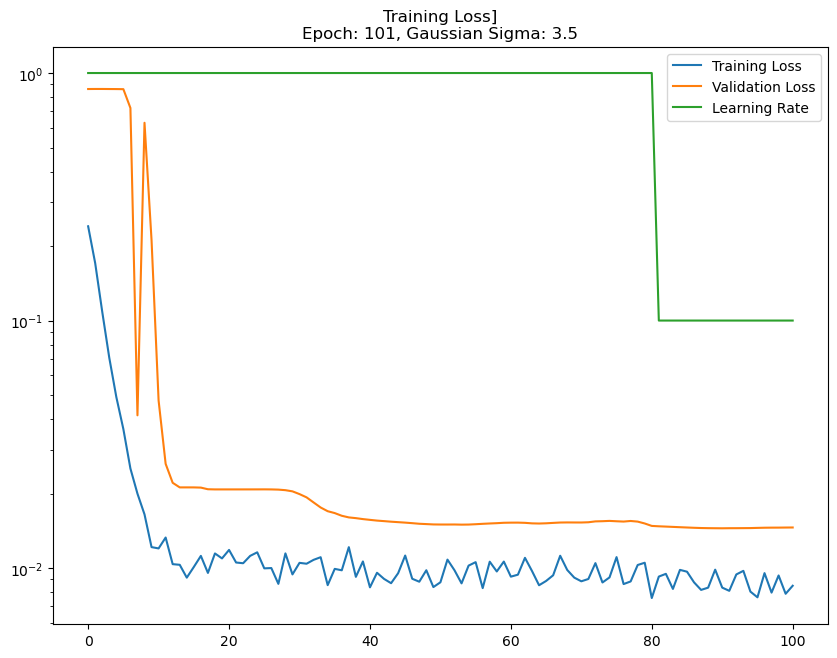

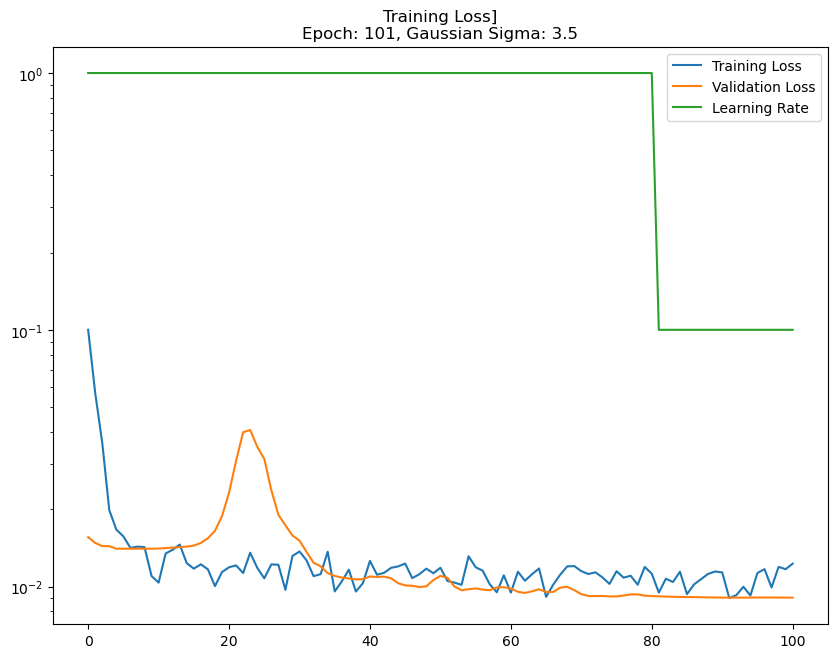

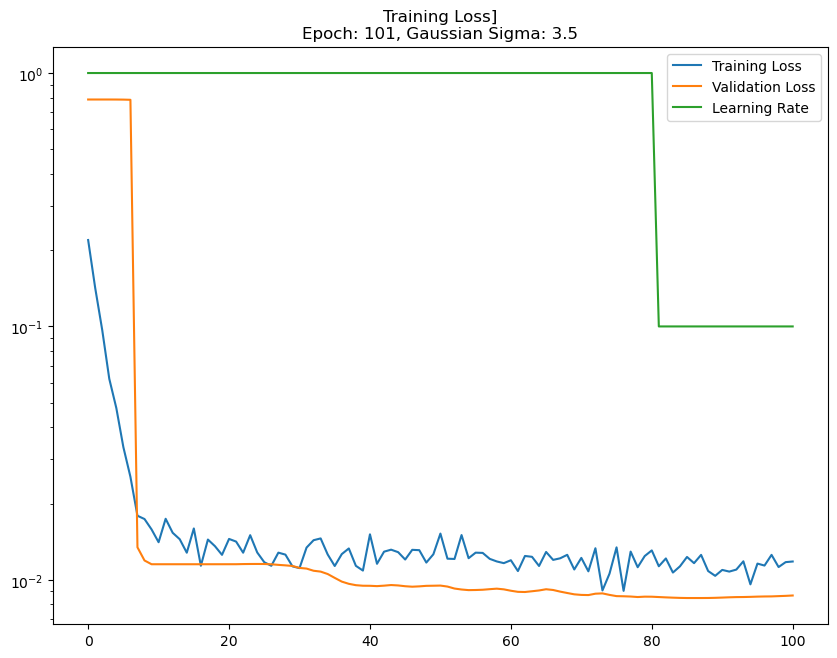

/gpfs/space/home/eckhardt/sanger/results/cellnet/240603-054345-sigma3_7-val-all-RUNNING/util/plot.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.savefig(path, transparent=transparent, pil_kwargs=dict(compress_level=9))


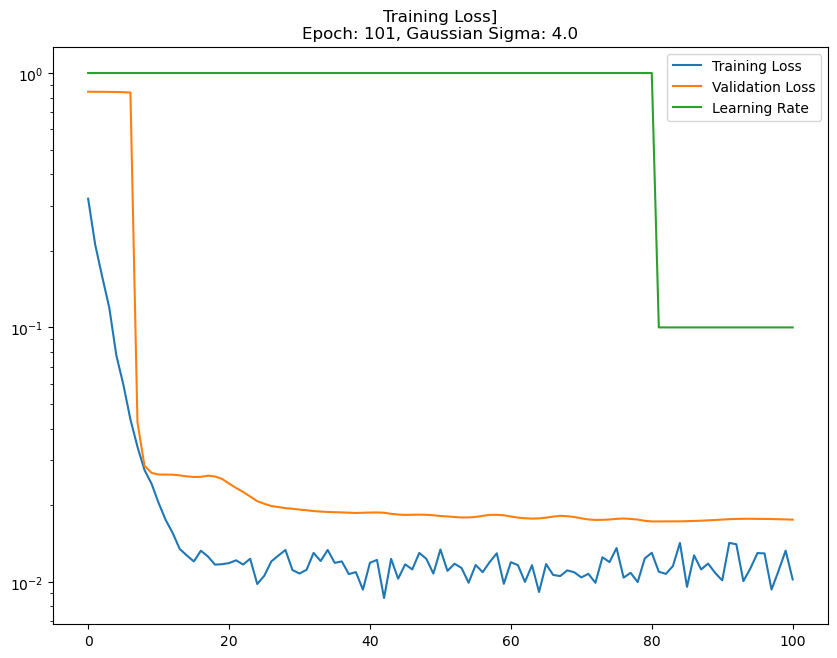

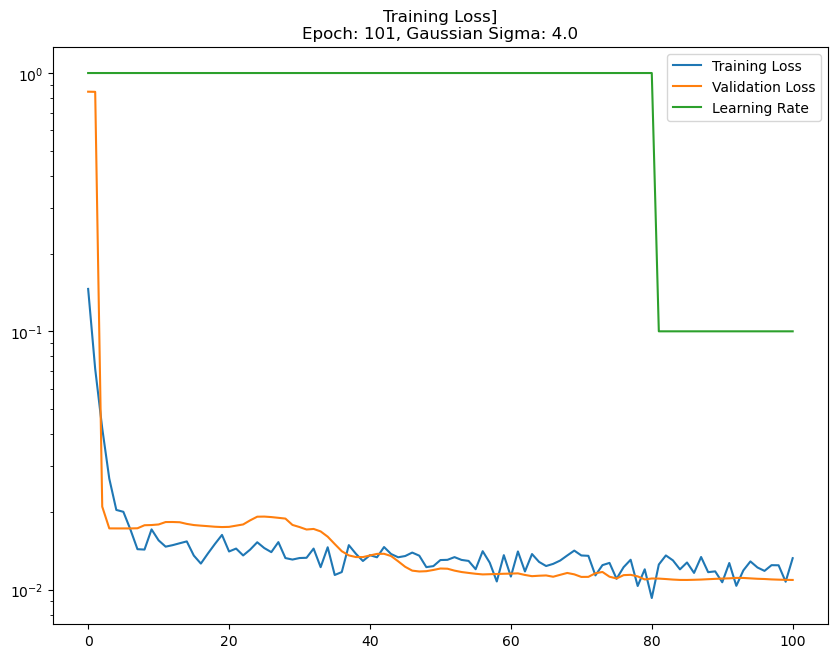

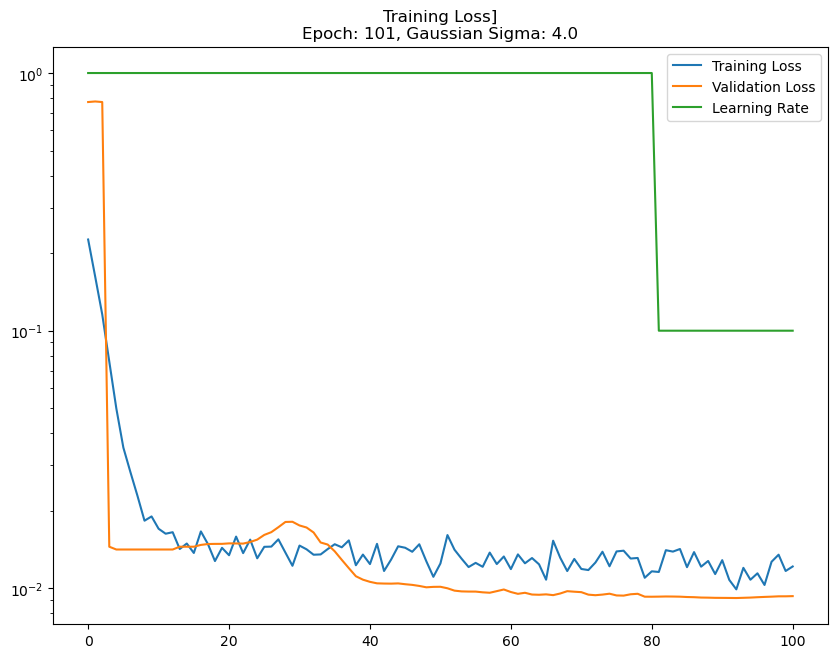

/gpfs/space/home/eckhardt/sanger/results/cellnet/240603-054345-sigma3_7-val-all-RUNNING/util/plot.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.savefig(path, transparent=transparent, pil_kwargs=dict(compress_level=9))


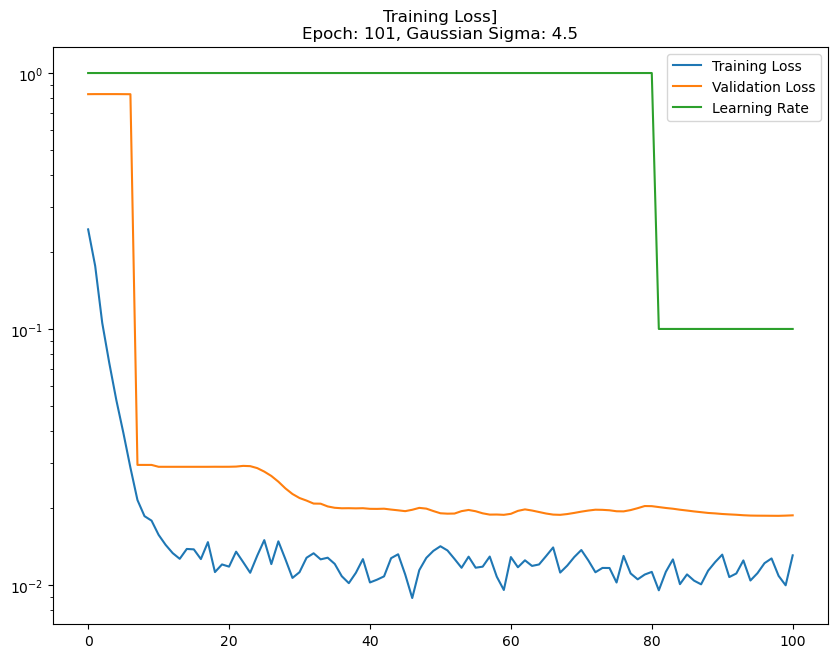

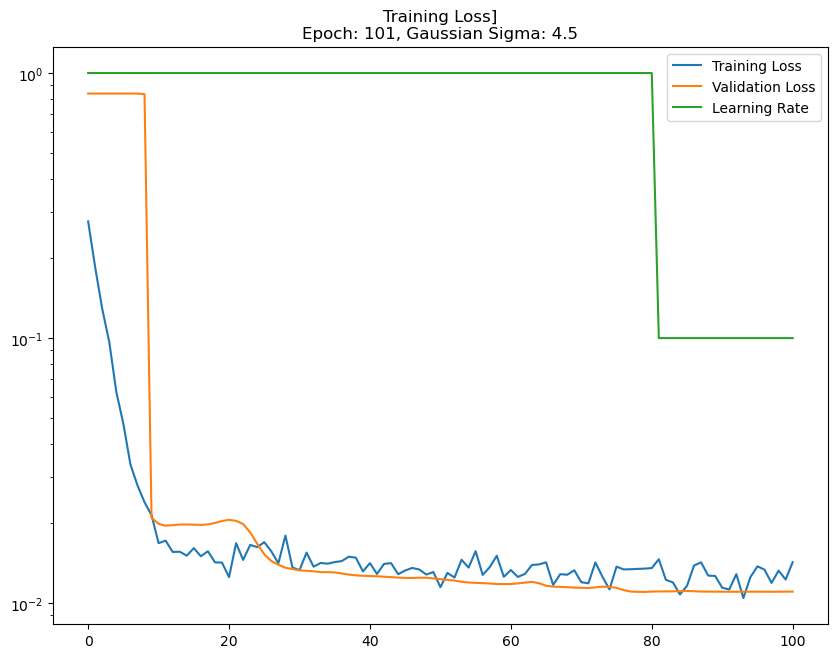

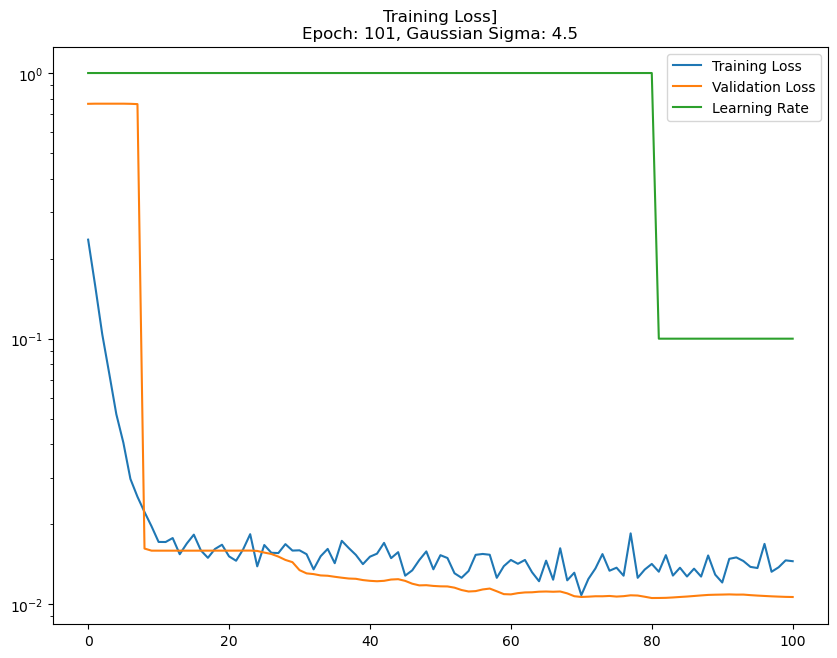

/gpfs/space/home/eckhardt/sanger/results/cellnet/240603-054345-sigma3_7-val-all-RUNNING/util/plot.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.savefig(path, transparent=transparent, pil_kwargs=dict(compress_level=9))


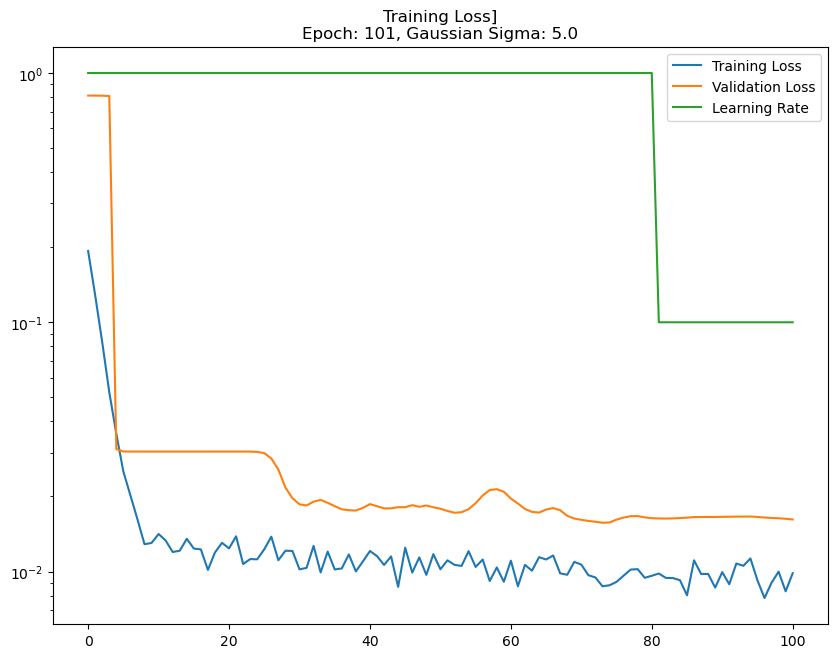

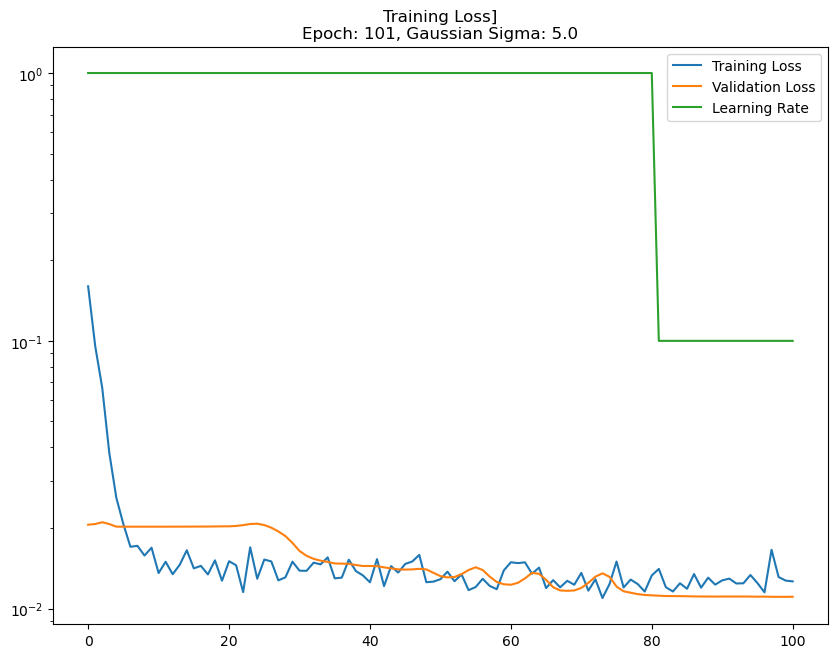

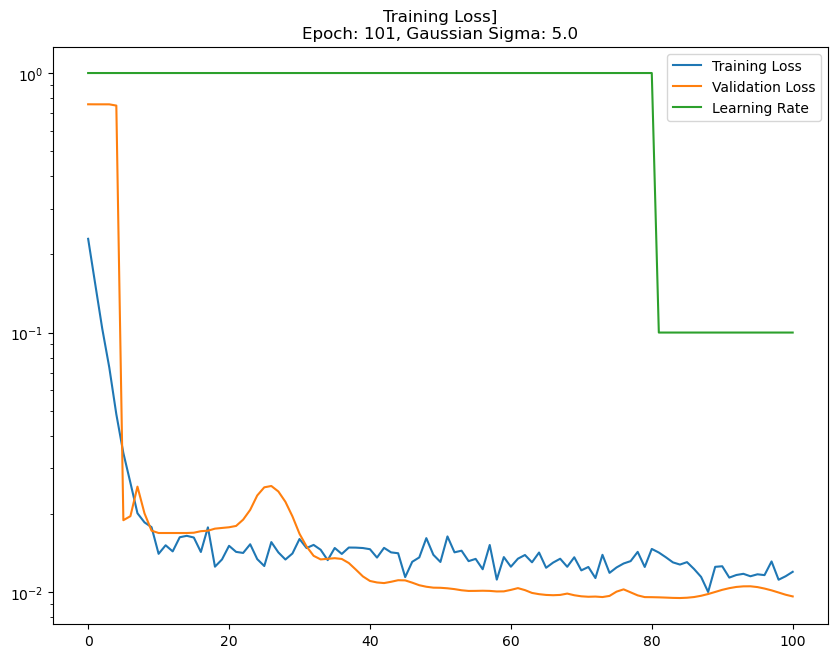

/gpfs/space/home/eckhardt/sanger/results/cellnet/240603-054345-sigma3_7-val-all-RUNNING/util/plot.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.savefig(path, transparent=transparent, pil_kwargs=dict(compress_level=9))


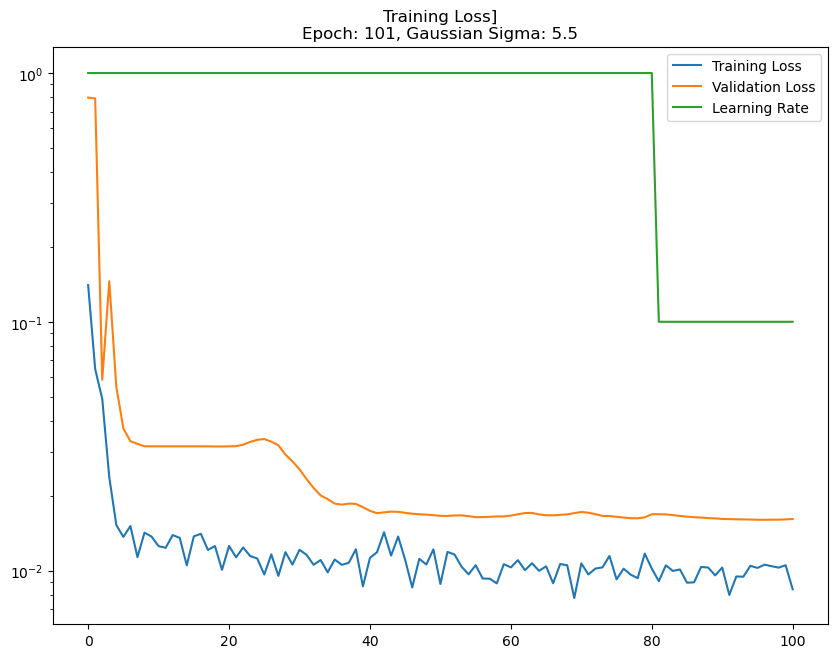

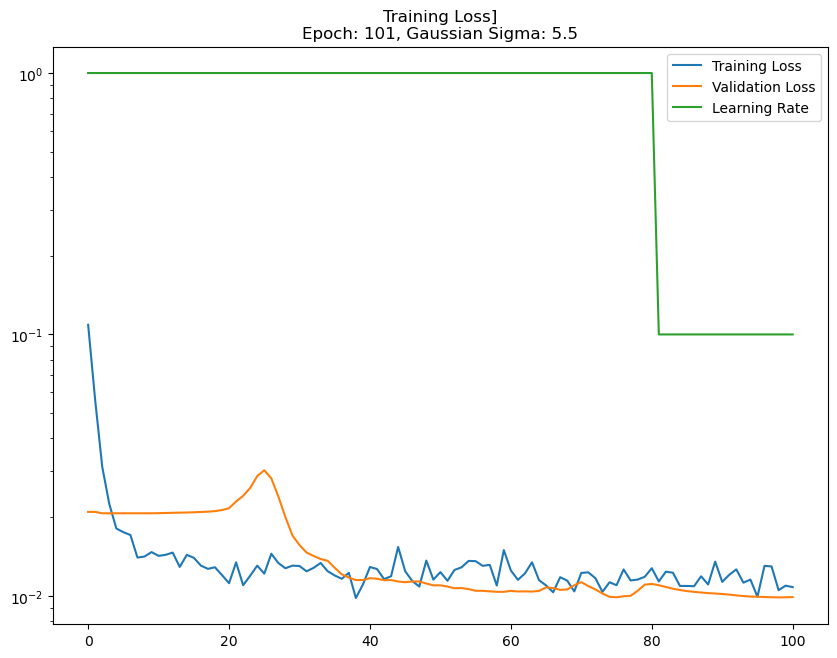

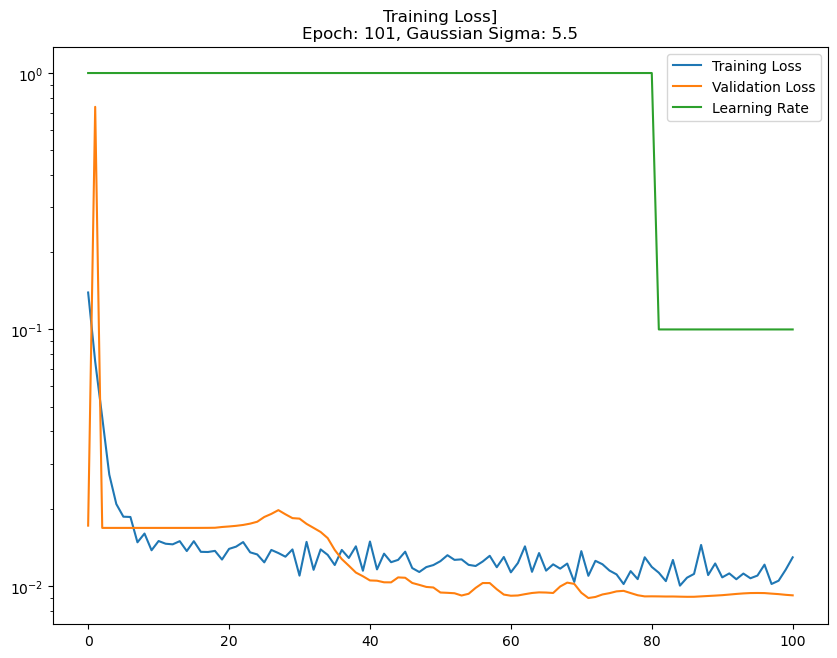

/gpfs/space/home/eckhardt/sanger/results/cellnet/240603-054345-sigma3_7-val-all-RUNNING/util/plot.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.savefig(path, transparent=transparent, pil_kwargs=dict(compress_level=9))


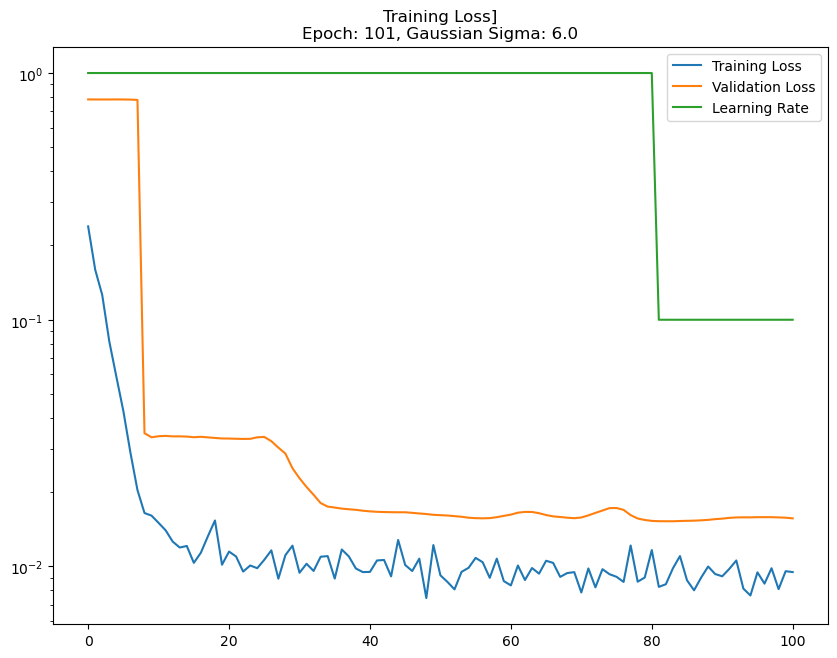

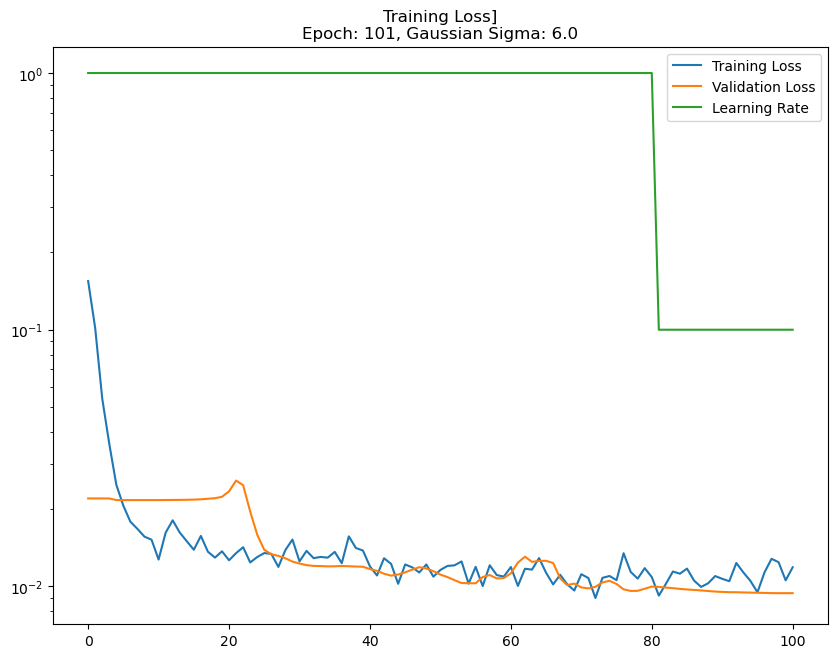

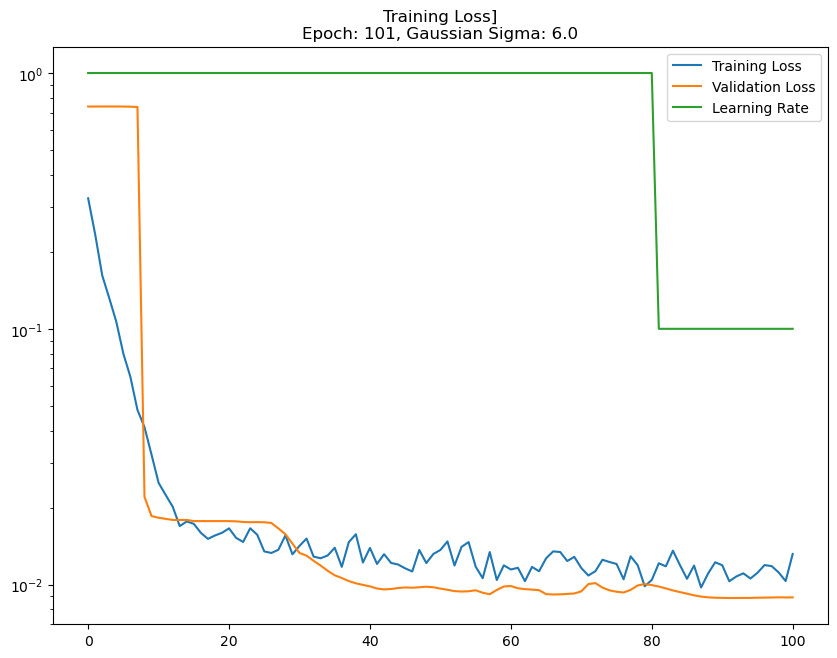

/gpfs/space/home/eckhardt/sanger/results/cellnet/240603-054345-sigma3_7-val-all-RUNNING/util/plot.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.savefig(path, transparent=transparent, pil_kwargs=dict(compress_level=9))


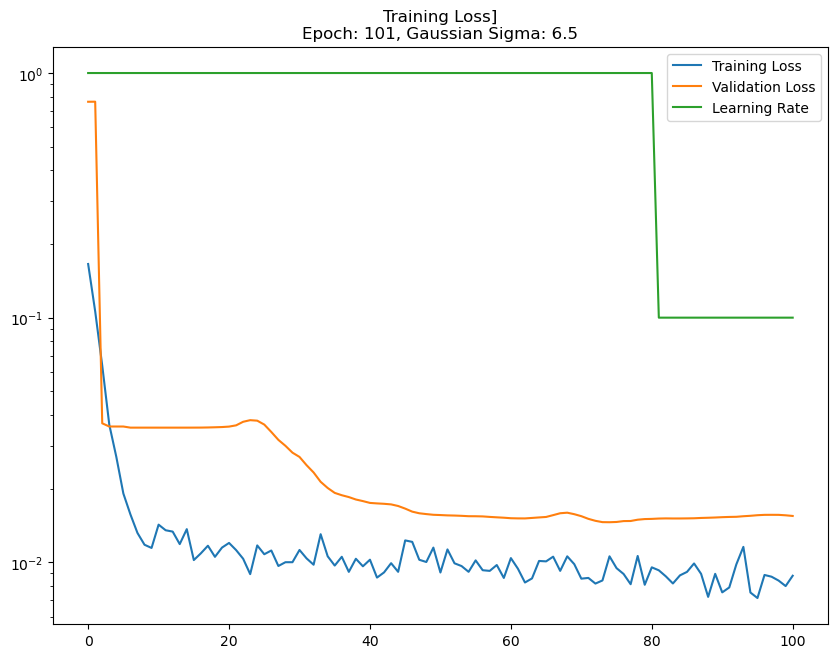

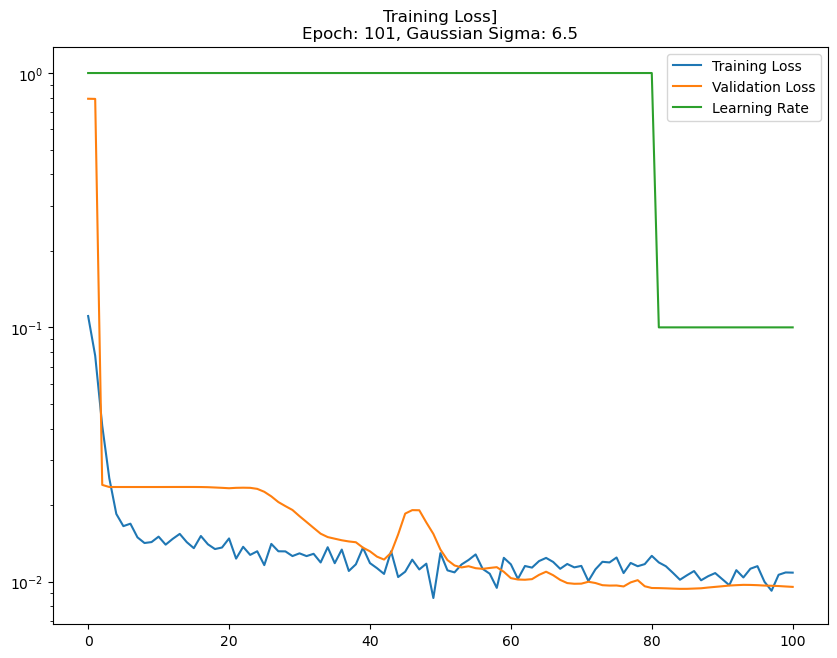

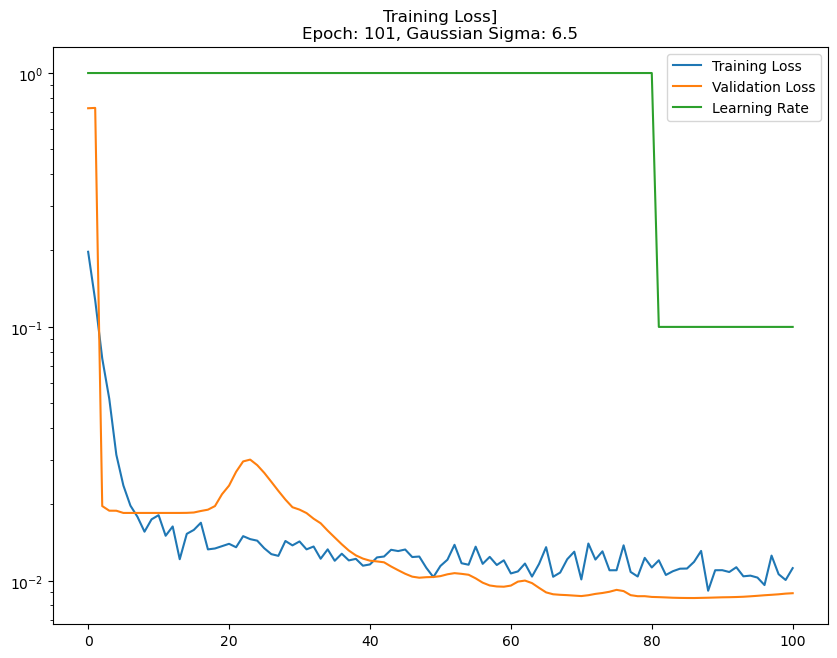

/gpfs/space/home/eckhardt/sanger/results/cellnet/240603-054345-sigma3_7-val-all-RUNNING/util/plot.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.savefig(path, transparent=transparent, pil_kwargs=dict(compress_level=9))


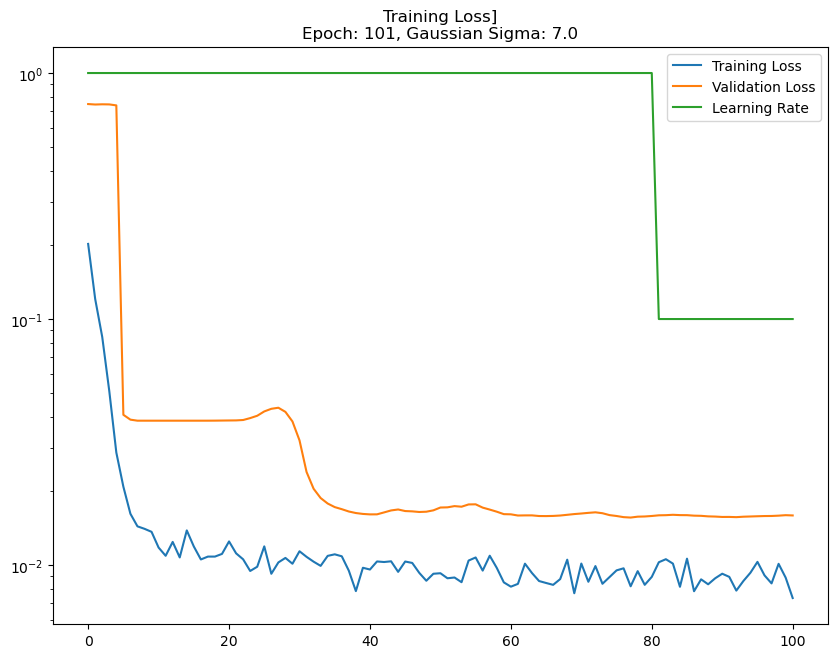

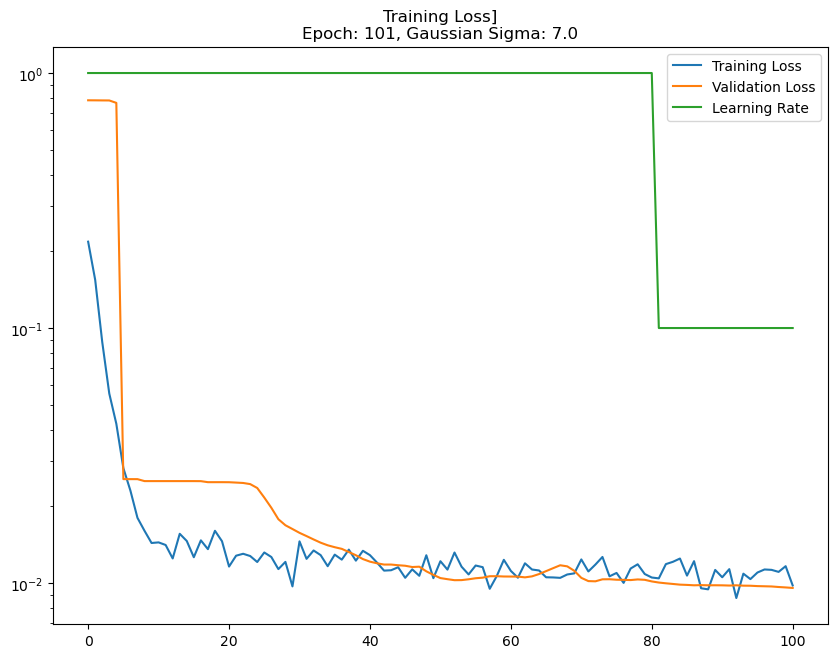

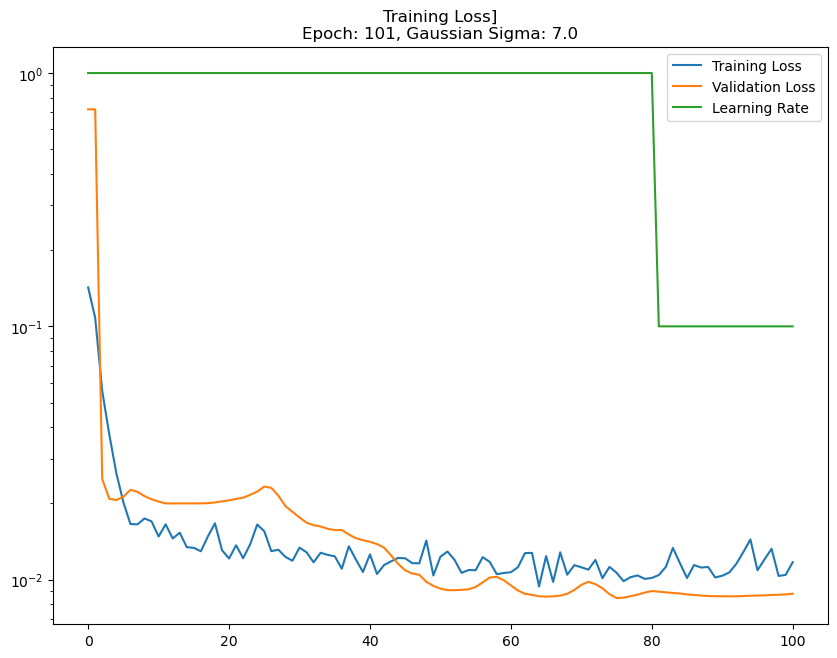

/gpfs/space/home/eckhardt/sanger/results/cellnet/240603-054345-sigma3_7-val-all-RUNNING/util/plot.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.savefig(path, transparent=transparent, pil_kwargs=dict(compress_level=9))


In [5]:

#def count(y): return yunnorm(y).sum().item()

def accuracy(y,z): 
  ny, nz = y.sum().item(), z.sum().item()
  return 1 - abs(ny - nz) / (nz+1e-9)

def train(epochs, model, optim, lossf, sched, kp2hm, traindl, valdl=None, info={}):
  log = pd.DataFrame(columns='tl vl ta va lr'.split(' '), index=range(epochs))
  def epoch(dl, train):
    l = 0; a = 0; b = 0
    for b, B in enumerate(dl):
      x,m = B['image'].to(device), B['masks'][0].to(device)
      z = kp2hm(B).to(device)

      y = model(x)
      loss = lossf(y*m, z*m) 
      l += loss.item()
      a += accuracy(y*m, z*m) # type: ignore

      if train:
        loss.backward()
        optim.step()
        optim.zero_grad()

    return l/(b+1), a/(b+1)

  for e in range(epochs):
    L = log.loc[e]
    L['lr'] = optim.param_groups[0]['lr']
  
    model.train()
    L['tl'], L['ta'] = epoch(traindl, train=True)
    sched.step() 
  
    if valdl is not None: 
      model.eval()
      with torch.no_grad():
        L['vl'], L['va'] = epoch(valdl, train=False) 

    if DRAFT: plot.train_graph(e, log, info=info, key2text=key2text, clear=True)
  plot.train_graph(epochs, log, info=info, key2text=key2text, accuracy=False) 
  return log

def loss_per_point(b, lossf, kernel=15):
  loss = lossf.__class__(reduction='none')(*[torch.tensor(x) for x in [b.y, b.z]])

  p2L = np.zeros(len(b.l))
  for i, (l, (x,y)) in enumerate(zip(b.l, b.k)):
    xx, yy = np.meshgrid(np.arange(loss.shape[2]), np.arange(loss.shape[1]))
    kernel = (xx-x)**2 + (yy-y)**2 < kernel**2
    p2L[i] = (loss * kernel).sum()

  return p2L


splits = [([1], [2])] if DRAFT else dict(
  one = [([1], [2,4])],
  all = [([2,4], [1]), ([1,4], [2]), ([1,2], [4])],
)[IMAGES]

results = pd.DataFrame()
if not DRAFT: [os.makedirs(p, exist_ok=True) for p in ('preds', 'plots')]
def training_run(cfg, traindl, valdl, kp2hm, model=None):
  global results  
  ti=traindl.dataset.ids; vi=valdl.dataset.ids

  if model is None: model = mk_model()
  optim = torch.optim.Adam(model.parameters(), lr=5e-3)
  lossf = torch.nn.MSELoss()
  sched = torch.optim.lr_scheduler.StepLR(optim, step_size=int(cfg.epochs/cfg.lr_steps)+1, gamma=cfg.lr_gamma)

  log = train(cfg.epochs, model, optim, lossf, sched, kp2hm, traindl, valdl, info={P: p})

  _row =  pd.DataFrame(dict(**{P: [p]}, ti=[ti], vi=[vi], **log.iloc[-1]))
  results = _row if results.empty else pd.concat([results, _row], ignore_index=True)

  i2p2L = {}
  # plot and save predictions to disk
  for ii, t in [(ti, 'T'), (vi, 'V')]:
    for i in ii:
      B = next(iter(data.mk_loader([i], bs=1, transforms=mkAugs('test'), shuffle=False, cfg=cfg)))

      model.eval()
      with torch.no_grad(): y = cpu(model(B['image'].to(device)))
      B = batch2cpu(B, z=kp2hm(B), y=y)[0]

      if cfg.rmbad != 0: # get the badly predicted points and plot them
        i2p2L[i] = loss_per_point(B, lossf, kernel=15)
        rm = np.argsort(-i2p2L[i])[:int(len(B.l)*cfg.rmbad)]

      if vi==[4]:  # plot
        ax1 = plot_overlay(B, cfg, heat='y') 
        ax2 = plot_diff   (B, cfg)

        if cfg.rmbad != 0: 
          [plot.points(a, B.k[rm], B.l[rm], 15, color='#444400', lw=3)
            for a in (ax1, ax2)]

        if not DRAFT :  # save but don't show
          id = f"{P}={p}-{t}{i}"
          #np.save(f'preds/{id}.npy', y)
          plot.save(ax1, f'plots/{id}.pred.png')
          plot.save(ax2, f'plots/{id}.diff.png')
        if not DRAFT:
          plt.close('all')

  return dict(model=model, log=log, i2p2L=i2p2L)


cfg_base = obj(
  epochs=(5 if CUDA else 1) if DRAFT else 101,
  sigma=3.5,  # NOTE: put optimal sigma here
  maxdist=26, 
  fraction=1, 
  sparsity=1,
  lr_steps=1.25,
  lr_gamma=0.1,
  rmbad=0,
)

if P not in ['sigma']: kp2hm, yunnorm = data.mk_kp2mh_yunnorm([1,2,4], cfg_base)


for p in [1] if DRAFT else ps:
  cfg = obj(**(cfg_base.__dict__ | {P: p}))
  if P in ['sigma']: kp2hm, yunnorm = data.mk_kp2mh_yunnorm([1,2,4], cfg)

  for ti, vi in splits:
    cfg = obj(**(cfg.__dict__ | dict(ti=ti, vi=vi)))

    loader = lambda c, ids, mode: data.mk_loader(ids, bs=1 if mode=='test' else 16, transforms=mkAugs(mode), shuffle=False, cfg=c)
    traindl, valdl = loader(cfg, ti, AUGS), loader(cfg, vi, 'val' if AUGS=='train' else 'test')

    out = training_run(cfg, traindl, valdl, kp2hm)

    if cfg.rmbad != 0:
      keep = {i: np.argsort(-p2L)[int(len(p2L)*cfg.rmbad):] for i,p2L in out['i2p2L'].items()}

      cfg = obj(**(cfg.__dict__ | dict(epochs=cfg.epochs//2+1, rmbad=0.1)))

      traindl, valdl = loader(cfg, ti, AUGS), loader(cfg, vi, 'val' if AUGS=='train' else 'test')
      # remove the hard to predict annotations
      for ds in [traindl.dataset, valdl.dataset]:
        ds.P = {i: ds.P[i][keep[i]] for i in ds.P}
        ds.L = {i: ds.L[i][keep[i]] for i in ds.L}
        ds._generate_masks(fraction=0, sparsity=0)  # regenerate masks, but don't throw away more data

      
      out = training_run(cfg, traindl, valdl, kp2hm, model=out['model'])

,sigma,ti,Validation Image,tl,vl,ta,va,lr
0,3.0,"[2, 4]",[1],0.008571,0.012192,0.953709,0.781824,0.1
1,3.0,"[1, 4]",[2],0.009507,0.008023,0.988466,0.914927,0.1
2,3.0,"[1, 2]",[4],0.008931,0.006922,0.830620,0.822794,0.1
3,3.5,"[2, 4]",[1],0.008484,0.014589,0.882785,0.728232,0.1
4,3.5,"[1, 4]",[2],0.012285,0.009055,0.899372,0.844561,0.1
5,3.5,"[1, 2]",[4],0.011814,0.008674,0.993085,0.645366,0.1
6,4.0,"[2, 4]",[1],0.010216,0.017550,0.986843,0.755128,0.1
7,4.0,"[1, 4]",[2],0.013236,0.010901,0.936540,0.941309,0.1
8,4.0,"[1, 2]",[4],0.012160,0.009330,0.990867,0.789141,0.1
9,4.5,"[2, 4]",[1],0.013045,0.018695,0.953695,0.674512,0.1


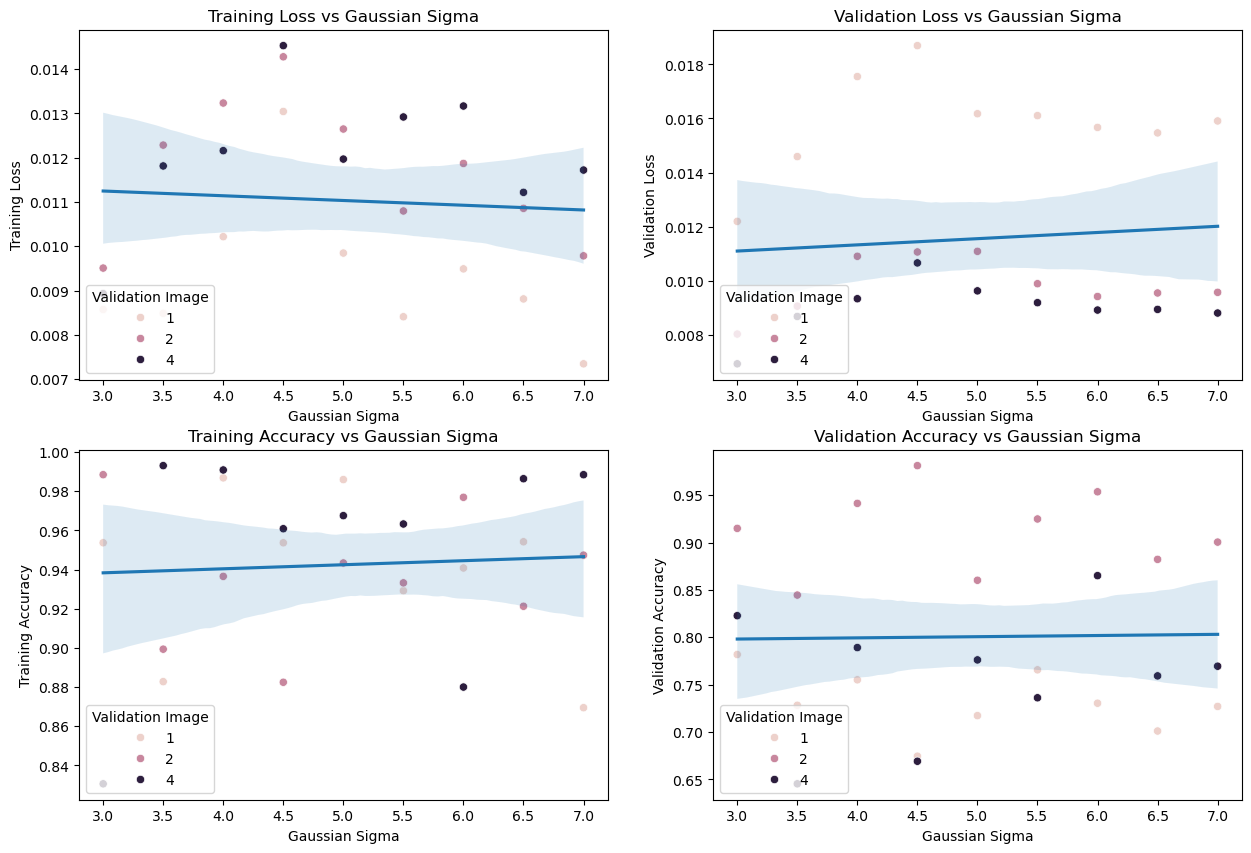

In [2]:

if True or not DRAFT:
  #results.to_csv('results.csv', index=False, sep=';')
  R = pd.read_csv('results.csv', sep=';', converters=dict(ti=ast.literal_eval, vi=ast.literal_eval)).rename(columns=dict(vi=key2text['vi']))
  plot.regplot(R, P, key2text)

R